# CICE crash investigation in ACCESS-OM2_01

Author: Andrew Kiss

In [1]:
%matplotlib inline

from glob import glob
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from tqdm import tqdm_notebook
from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
from netCDF4 import Dataset
import cmocean as cm
import string

/home/156/aek156/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# figdir = 'figures/access-om2-01/Ice_Daily_ACCESS-OM2-01/'
figdir = '/g/data/v45/aek156/figures/access-om2-01/Ice_Crash_ACCESS-OM2-01/'
if not os.path.exists(figdir):
    os.makedirs (figdir)

def savefigure(fname):
#     plt.savefig(os.path.join(figdir, fname),dpi=100, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname),dpi=50, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
# model data paths:
model = 'access-om2-01'
expt = '01deg_jra55v13_ryf8485_spinup6'
DataDir = os.path.join('/g/data3/hh5/tmp/cosima/', model)
expdir = os.path.join(DataDir, expt)
# date = '0004-07-05' # nicest view
# date = '0004-07-12'
# fn01 = '/g/data3/hh5/tmp/cosima/' + model + '/' +  expt + '/output023/ice/OUTPUT/iceh.' + date + '.nc'

In [4]:
# get model grid data:
gridFileList = glob(os.path.join(expdir, 'output*/ocean/ocean_grid.nc'))
gridFileList.sort()
ncFile = nc.Dataset(gridFileList[0], mode='r')
xt_ocean = ncFile.variables['xt_ocean'][...]
yt_ocean = ncFile.variables['yt_ocean'][...]
lon_t = ncFile.variables['geolon_t'][...]
lat_t = ncFile.variables['geolat_t'][...]
area_t = ncFile.variables['area_t'][...]
# NLAT_half = int(np.shape(area_t)[0]/2)
ht = ncFile.variables['ht'][...]
land_mask = np.copy(ht)
land_mask[np.where(ht>30)] = 0
land_mask[np.where(ht<=30)] = 1

HBox(children=(IntProgress(value=0, description='variables', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='views', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='day', max=31), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/numpy/ma/core.py:6468: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch func

KeyboardInterrupt: 

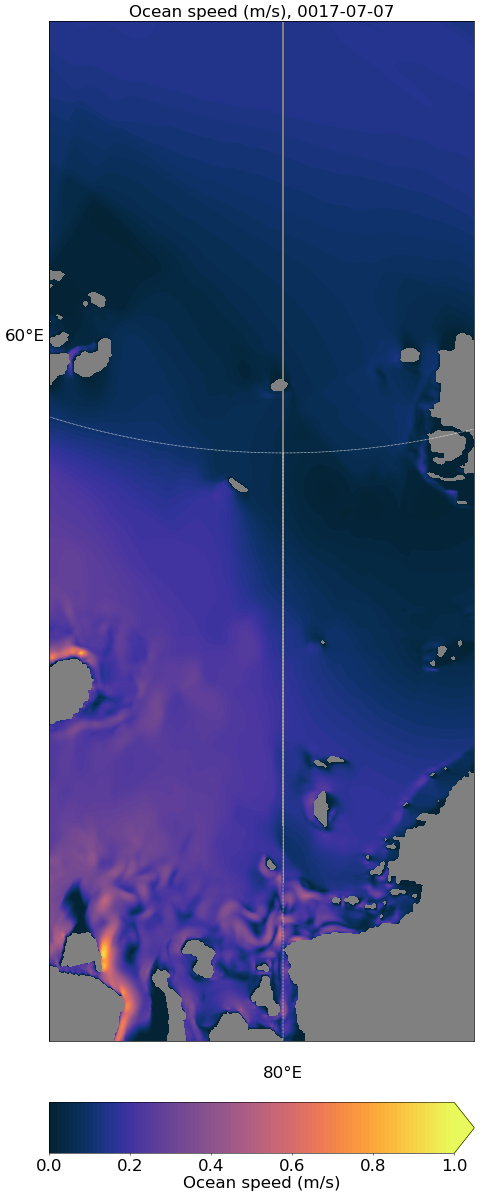

In [8]:
icehFileList = glob(os.path.join(expdir, 'output*/ice/OUTPUT/iceh.0017-07-*.nc'))  # /g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_spinup6/output185/ice/OUTPUT
icehFileList.sort()

varnames = ['hi', 'aice', 'uvel', 'vvel', 'divu', 'shear', 'sig1', 'sig2', 'strairx', 'strairy', 'uocn', 'vocn', 'sst', 'sss']

varnames = ['hi', 'aice','uvel', 'vvel', 'shear', 'uocn', 'vocn', 'strairx', 'strairy', 'divu']

# varnames = ['uvel', 'vvel', 'strairx', 'strairy']

varnames = ['aice']

# varnames = ['uvel']

varnames = ['icespeed', 'oceanspeed']

varnames = ['oceanspeed']


# views = ['Arctic_closeup', 'Arctic', 'Antarctic']
views = ['Aug_crash', 'May_crash', 'tripole_bug', 'Arctic_closeup', 'Arctic', 'Antarctic']

views = ['tripole_bug']


# views = ['Aug_crash_x']



# TODO: swap loop order to reuse data for multiple views (need to change skipping logic)

for varname in tqdm_notebook(varnames, leave=False, desc='variables'):
    for view in tqdm_notebook(views, leave=False, desc='views'):
        for fpath in tqdm_notebook(icehFileList, leave=False, desc='day'):
            fname=os.path.basename(fpath)
            date = fname.split('.')[1]
            month = int(date.split('-')[1])
            outname = view + '_' + varname + '_' + date + '.png'

            if os.path.exists(os.path.join(figdir, outname)):
                print('Skipping ' + outname + ' (file exists)')
            else:
                nc = Dataset(fpath, mode='r')
                if varname.endswith('speed'):
                    if varname == 'icespeed':
                        u = nc.variables['uvel'][:][0,:,:]
                        v = nc.variables['vvel'][:][0,:,:]
                    elif varname == 'icespeed':
                        u = nc.variables['uocn'][:][0,:,:]
                        v = nc.variables['vocn'][:][0,:,:]
                    var = np.ma.sqrt(u**2 + v**2)  # u,v are co-located on B grid
                else:
                    var = nc.variables[varname][:][0,:,:]
                varmask = np.ma.getmask(var)
                nc.close()
                if varname == 'aice':
                    desc = 'Ice concentration'
                    levels = np.arange(0,1.01,.01)
                    ticks = [0,.2,.4,.6,.8,1]
                    ext = 'neither'
                    cmp = cm.cm.ice
                elif varname == 'hi':
                    desc = 'Ice thickness (m)'
                    levels = np.arange(0,6.01,.06)
                    ticks = range(7)
                    ext = 'max'
                    cmp = cm.cm.ice
                elif varname == 'uvel':
                    desc = 'Ice x velocity (m/s)'
                    levels = np.arange(-1,1.01,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.2)
                    ext = 'both'
                    cmp = cm.cm.balance
                elif varname == 'vvel':
                    desc = 'Ice y velocity (m/s)'
                    levels = np.arange(-1,1.01,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.2)
                    ext = 'both'
                    cmp = cm.cm.balance
                elif varname == 'uocn':
                    desc = 'Ocean x velocity (m/s)'
                    levels = np.arange(-1,1.01,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.2)
                    ext = 'both'
                    cmp = cm.cm.balance
                elif varname == 'vocn':
                    desc = 'Ocean v velocity (m/s)'
                    levels = np.arange(-1,1.01,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.2)
                    ext = 'both'
                    cmp = cm.cm.balance
                elif varname == 'icespeed':
                    desc = 'Ice speed (m/s)'
                    levels = np.arange(0,1.01,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.2)
                    ext = 'max'
                    cmp = cm.cm.thermal
                elif varname == 'oceanspeed':
                    desc = 'Ocean surface speed (m/s)'
                    levels = np.arange(0,1.01,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.2)
                    ext = 'max'
                    cmp = cm.cm.thermal
                elif varname == 'divu':
                    desc = 'Ice divergence rate (%/day)'
                    levels = np.arange(-1000,1000.01,20)
                    ticks = np.rint(np.arange(levels[0],levels[-1]+.001,250.0))
#                     var = np.copysign(np.log10(np.abs(var)), var)
#                     desc = 'Log of ice divergence rate (%/day)'
#                     levels = np.arange(-3,3.01,.05)
#                     ticks = np.rint(np.arange(levels[0],levels[-1],1.0))
                    ext = 'both'
                    cmp = cm.cm.balance
                elif varname == 'shear':
# #                     desc = 'Ice strain rate (shear) (%/day)'
# #                     levels = np.arange(0,300.01,10)
# #                     ticks = np.rint(np.arange(levels[0],levels[-1],30.0))
# #                     ext = 'max'
# #                     noice = (var <= 0).astype('int')
#                     varcopy = var
# # #                     var = np.copysign(np.log10(np.abs(var)), var)
# #                     var = np.log10(var)
# #                     var = np.where(varcopy<=0, -2, var)
# #                     var = np.where(varcopy==np.nan, np.nan, var)
                    var = np.where(var>0, np.log10(var), -2)
#                     var = np.ma.masked_where(np.ma.getmask(varcopy),var)
                    desc = 'Log of ice shear rate (%/day)'
                    levels = np.arange(-2,3.01,.05)
                    ticks = np.rint(np.arange(levels[0],levels[-1]+.001,1.0))
                    ext = 'both'
                    cmp = cm.cm.thermal
                elif varname == 'strairx':
                    desc = 'Wind stress, x direction (Pa)'
                    levels = np.arange(-0.5,0.501,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.1)
                    ext = 'both'
                    cmp = cm.cm.balance
                elif varname == 'strairy':
                    desc = 'Wind stress, y direction (Pa)'
                    levels = np.arange(-0.5,0.501,.01)
                    ticks = np.arange(levels[0],levels[-1]+.001,0.1)
                    ext = 'both'
                    cmp = cm.cm.balance
                elif varname == 'sst':
                    desc = 'SST (C)'
                    levels = np.arange(-3,10.1,.25)
#                     ticks = np.arange(levels[0],levels[-1]+.001,2)
                    ticks = np.arange(-4,100,2)
                    ext = 'both'
#                     cmp = plt.cm.gist_ncar
                    cmp = cm.cm.thermal
                else:
                    desc = '***UNKNOWN***'
                    levels = np.arange(0,1.01,.1)
                    ticks = [0,.2,.4,.6,.8,1]
                    ext = 'neither'
                    
                var = np.ma.masked_where(varmask,var)


                font = {'size':24}
                tick_font=24

                fig = plt.figure(figsize=(30,30))
                if view == 'Arctic':
                    m = Basemap(projection ='npstere',boundinglat=45,lon_0=-10,resolution='l')
                elif view == 'Arctic_closeup':
                    m = Basemap(projection ='npstere',boundinglat=70,lon_0=-10,resolution='l')
                elif view == 'Aug_crash':
                    m = Basemap(projection='stere',llcrnrlat=67,urcrnrlat=75,
                                llcrnrlon=-110,urcrnrlon=-90,lat_0=75,lon_0=-100,resolution='l')
                elif view == 'May_crash':
                    m = Basemap(projection='stere',llcrnrlat=66,urcrnrlat=85,
                                llcrnrlon=70,urcrnrlon=110,lat_0=75,lon_0=80,resolution='l')
                elif view == 'tripole_bug':
                    m = Basemap(projection='stere',llcrnrlat=72,urcrnrlat=85,
                                llcrnrlon=70,urcrnrlon=110,lat_0=75,lon_0=80,resolution='l')
                else:
                    m = Basemap(projection ='spstere',boundinglat=-50,lon_0=170,resolution='l')

                # m = Basemap(projection ='ortho',resolution='l',lat_0=90,lon_0=45,
                #            llcrnrx=-m.urcrnrx/2.,llcrnry=-m.urcrnry/2.,urcrnrx=m.urcrnrx/2.,urcrnry=m.urcrnry/2.)
                # #             llcrnrlat=60,urcrnrlat=60,
                # #             llcrnrlon=-45,urcrnrlon=45)
                # #             llcrnrlon=loncorners[0],urcrnrlon=loncorners[2]) ,boundinglat=48
                x,y = m(*(lon_t,lat_t))
                ctr = m.contourf(x,y,var,levels=levels,cmap=cmp, extend=ext) #, vmin=0, vmax=1.1)
                ctr.cmap.set_under(color=cmp(np.min(levels)), alpha=None)
                ctr.cmap.set_over(color=cmp(np.max(levels)), alpha=None)
#                 if view.startswith('Arctic'):
#                     xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
#                     m.contour(xobs,yobs,CN_obs_NH[month-1],[0.3],colors='r')
#                 else:
#                     xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
#                     m.contour(xobs,yobs,CN_obs_SH[month-1],[0.3],colors='r')

                plt.title(desc + ', ' + date,font)
                cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
                cbar.set_label(desc,size=tick_font)
                cbar.set_ticks(ticks)
                cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
                plt.setp(cbar_labels,fontsize=tick_font)
                m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
                # fill continents, set lake color same as ocean color.
                # m.fillcontinents(color='gray',lake_color='gray')
                # draw parallels and meridians.
                # label parallels on right and top
                # meridians on bottom and left
                parallels = np.arange(-80.,81,10.)
                # labels = [left,right,top,bottom]
                m.drawparallels(parallels,color='white')#,labels=[False,True,True,False],size=tick_font)
                meridians = np.arange(0.,351.,20.)
                m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white')
                savefigure(outname)
                plt.close()